House pricing project

In [81]:
# Load the libraries
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import cufflinks as cf
import seaborn as sns
import missingno as msno
import statistics

from sklearn.ensemble import RandomForestRegressor

#import plotly.graph_objects as go
#import chart_studio.plotly as py 
#import plotly.plotly as py

#from plotly.offline import init_notebook_mode, iplot#, chart_studio
#from plotly.graph_objs import *
#init_notebook_mode()
#https://github.com/plotly/plotly.py/issues/1660

Data cleaning

In [2]:
# Find out your current working directory - used for uploading files from PC
#print(os.getcwd())
# Change directory 
os.chdir('PythonProject')
# import os
print(os.getcwd())
# Display all of the files found in your current working directory
print(os.listdir(os.getcwd()))

C:\Users\aarut\PythonProject
['14100223.csv', '18100205.csv', '34100127.csv']


In [3]:
# Read data (from local dir - some files too big to upload to Github)
housing_index = pd.read_csv('18100205.csv')
employment_data = pd.read_csv('14100223.csv') 
vacancy_rate = pd.read_csv('34100127.csv')

In [4]:
# preview data - housing index
housing_index.head(3)

#target variable is VALUE

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
2,1981-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,NaN,NaN,NaN,1


In [5]:
#in the analysis only house price will be used. Create a dataframe with New housing price indexes = house only
housing_index2 = housing_index.loc[(housing_index['New housing price indexes'])  == 'House only']
                                    
housing_index2.head(3)                                    

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
4,1981-01,Atlantic Region,2016A00011,House only,"Index, 201612=100",347,units,0,v111955446,2.2,NaN,..,NaN,NaN,1
7,1981-01,Newfoundland and Labrador,2016A000210,House only,"Index, 201612=100",347,units,0,v111955449,3.2,NaN,..,NaN,NaN,1


In [6]:
housing_index2.describe()
#column decimals have only one value (1), column scalar_id has only one value (0), UOM_ID has only one value (347), columns will not be useful for the analysis, can be removed
#columns symbol and terminated contain no entries, should be also removed
#count of value is lower than count of other columns, missing values need to be further investigated

,UOM_ID,SCALAR_ID,COORDINATE,VALUE,SYMBOL,TERMINATED,DECIMALS
count,18720.0,18720.0,18720.000000,15098.000000,0.0,0.0,18720.0
mean,347.0,0.0,20.700000,73.201099,NaN,NaN,1.0
std,0.0,0.0,11.543705,26.723279,NaN,NaN,0.0
min,347.0,0.0,1.200000,20.700000,NaN,NaN,1.0
25%,347.0,0.0,10.950000,50.800000,NaN,NaN,1.0
50%,347.0,0.0,20.700000,76.250000,NaN,NaN,1.0
75%,347.0,0.0,30.450000,96.400000,NaN,NaN,1.0
max,347.0,0.0,40.200000,212.400000,NaN,NaN,1.0


In [7]:
#remove columns which will not be used / are blank
#SCALAR_FACTOR is paired with SCALAR_ID, UOM is paired with UOM_ID
housing_index2 = housing_index2.drop(["UOM","UOM_ID", "SCALAR_ID", "SCALAR_FACTOR", "SYMBOL", "TERMINATED", "DECIMALS", "New housing price indexes"], axis=1)


In [8]:
#preview data types
print(housing_index2.dtypes)


REF_DATE       object
GEO            object
DGUID          object
VECTOR         object
COORDINATE    float64
VALUE         float64
STATUS         object
dtype: object


In [9]:
#change data type to date
housing_index2["REF_DATE"] = pd.to_datetime(housing_index2["REF_DATE"])

#change data types to factor
housing_index2["GEO"] = housing_index2["GEO"].astype('category')
housing_index2["DGUID"] = housing_index2["DGUID"].astype('category')
housing_index2["STATUS"] = housing_index2["STATUS"].astype('category')

print(housing_index2.dtypes)

REF_DATE      datetime64[ns]
GEO                 category
DGUID               category
VECTOR                object
COORDINATE           float64
VALUE                float64
STATUS              category
dtype: object


In [10]:
# identify values with poor quality
housing_index2["STATUS"].value_counts(dropna=False)

# ".." not available for a specific reference period
# "E" use with caution
# "x" suppressed to meet the confidentiality requirements of the Statistics Act

NaN    15058
..      3582
x         40
E         40
Name: STATUS, dtype: int64

In [11]:
# remove rows with poor quality of data "E" and "x", 80 rows
housing_index2.drop(housing_index2[housing_index2['STATUS'] == "E"].index, inplace = True)
housing_index2.drop(housing_index2[housing_index2['STATUS'] == "x"].index, inplace = True)
housing_index2["STATUS"].value_counts(dropna=False)

NaN    15058
..      3582
x          0
E          0
Name: STATUS, dtype: int64

VALUE Missing Values: 3582
DATE Missing Values: 0
GEO Missing Values: 0
DGUID Missing Values: 468


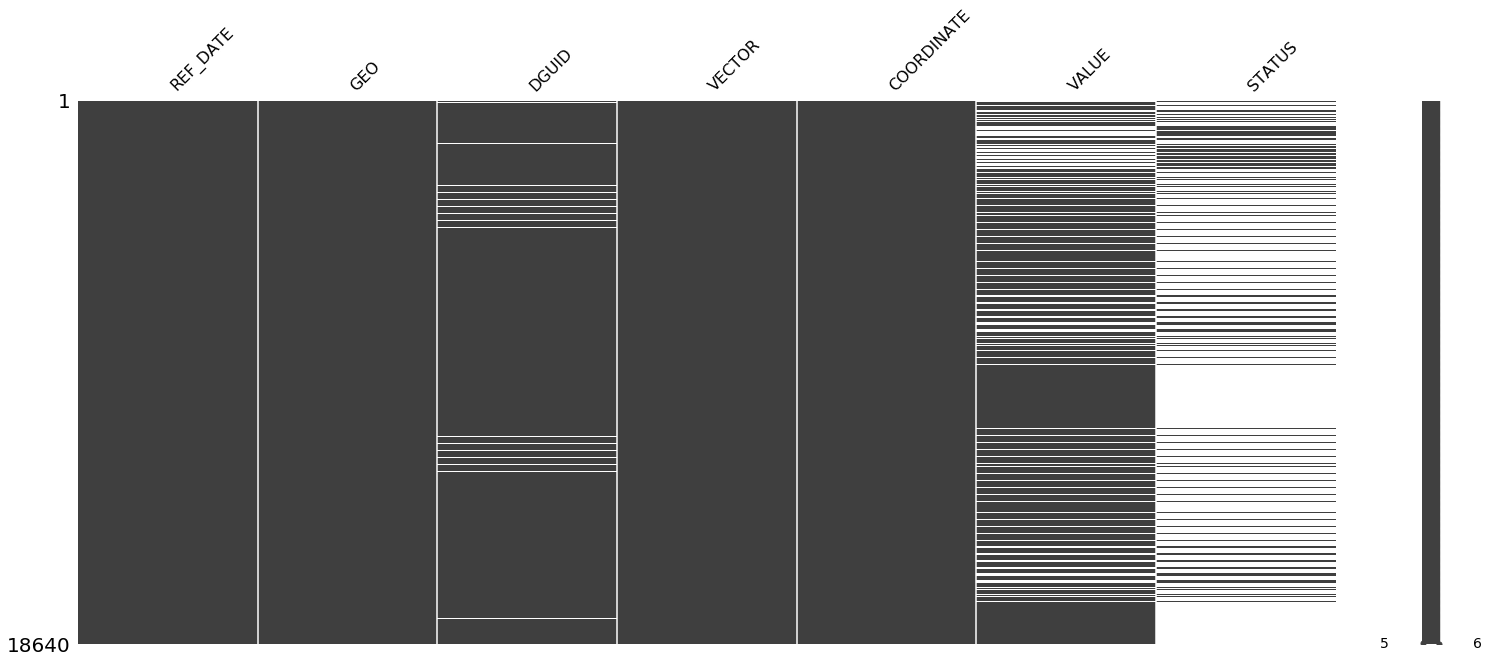

In [12]:
# check missing values

msno.matrix(housing_index2)

VALUE_msng_val_count = sum(pd.isnull(housing_index2['VALUE']))
print("VALUE Missing Values: {}".format(VALUE_msng_val_count))
DATE_msng_val_count = sum(pd.isnull(housing_index2['REF_DATE']))
print("DATE Missing Values: {}".format(DATE_msng_val_count))
GEO_msng_val_count = sum(pd.isnull(housing_index2['GEO']))
print("GEO Missing Values: {}".format(GEO_msng_val_count))
DGUID_msng_val_count = sum(pd.isnull(housing_index2['DGUID']))
print("DGUID Missing Values: {}".format(DGUID_msng_val_count))

# 3582 missing values for VALUE - corresponding with count of STATUS ".." not available for a specific reference period
# that is alomst 1/5 of all observations, need to check in which years / for which regions the missing values occur 
# check if missing values for DGUID can be added using GEO value

In [13]:
# replace missing values for DGUID by assigning mode of corresponding GEO value

housing_index2["DGUID"].value_counts(dropna=False)

NaN               468
2011S0503537      468
2011S0503602      468
2011S0503580      468
2011S0503559      468
2011S0503555      468
2011S0503550      468
2011S0503541      468
2011S0503539      468
2011S0503535      468
2016A000259       468
2011S0503532      468
2011S0503462      468
2011S0503442      468
2011S0503433      468
2011S0503421      468
2011S050335505    468
2011S050324505    468
2011S0503705      468
2011S0503725      468
2011S0503825      468
2011S0503835      468
2016A000248       468
2016A000247       468
2016A000246       468
2016A000235       468
2016A000224       468
2016A000213       468
2016A000212       468
2011S05031        468
2016A000210       468
2016A00014        468
2016A00011        468
2016A000011124    468
2011S0503935      468
2011S0503933      468
2011S0503915      468
2011S0504105      448
2016A000211       448
2011S0503205      428
Name: DGUID, dtype: int64

In [14]:
#create list of unique values of DGUID, without NaN
DGUID_set = set(housing_index2["DGUID"])
DGUID_set.pop()
DGUID_list = list(DGUID_set)
print(DGUID_list)

['2011S0503705', '2011S0503462', '2011S050335505', '2011S0503580', '2016A000011124', '2016A000246', '2016A000259', '2011S0503915', '2011S050324505', '2011S0504105', '2011S0503725', '2011S0503602', '2011S0503555', '2011S0503535', '2011S0503205', '2011S0503825', '2011S0503539', '2011S0503442', '2016A000210', '2011S0503835', '2011S0503421', '2016A000248', '2011S05031', '2011S0503550', '2016A000211', '2011S0503532', '2011S0503559', '2016A00014', '2016A000224', '2016A00011', '2011S0503541', '2011S0503935', '2011S0503433', '2011S0503537', '2016A000213', '2016A000235', '2016A000247', '2011S0503933', '2016A000212']


In [15]:
#assigning mode of GEO to missing values

#create empty list GEO_list
GEO_list = []

#for each element from DGUID_list 
for v in DGUID_list:
    #select columns DGUID and GEO, filter DGUID = DGUID_list[i]
    temp = housing_index2[housing_index2["DGUID"] == v]
    temp2 = temp[["DGUID","GEO"]]
    #calculate mode of GEO
    temp3 = statistics.mode(temp2["GEO"])
    #write DGUID and mode to list DGUID_GEO
    GEO_list.append(temp3)

print(GEO_list)
l = len(GEO_list)
print(l)



['Regina, Saskatchewan', 'Montréal, Quebec', 'Ottawa-Gatineau, Ontario part, Ontario/Quebec', 'Greater Sudbury, Ontario', 'Canada', 'Manitoba', 'British Columbia', 'Kelowna, British Columbia', 'Ottawa-Gatineau, Quebec part, Ontario/Quebec', 'Charlottetown, Prince Edward Island', 'Saskatoon, Saskatchewan', 'Winnipeg, Manitoba', 'London, Ontario', 'Toronto, Ontario', 'Halifax, Nova Scotia', 'Calgary, Alberta', 'St. Catharines-Niagara, Ontario', 'Trois-Rivières, Quebec', 'Newfoundland and Labrador', 'Edmonton, Alberta', 'Québec, Quebec', 'Alberta', "St. John's, Newfoundland and Labrador", 'Guelph, Ontario', 'Prince Edward Island', 'Oshawa, Ontario', 'Windsor, Ontario', 'Prairie Region', 'Quebec', 'Atlantic Region', 'Kitchener-Cambridge-Waterloo, Ontario', 'Victoria, British Columbia', 'Sherbrooke, Quebec', 'Hamilton, Ontario', 'New Brunswick', 'Ontario', 'Saskatchewan', 'Vancouver, British Columbia', 'Nova Scotia']
39


In [16]:
#create data frame DGUID_GEO

GEO_DGUID = pd.DataFrame({'GEO2': GEO_list, 'DGUID2': DGUID_list})

#remove balnks from the data frame
GEO_DGUID = GEO_DGUID.dropna()

#set index
s = GEO_DGUID.set_index('GEO2')['DGUID2']
print(s)

GEO2
Regina, Saskatchewan                               2011S0503705
Montréal, Quebec                                   2011S0503462
Ottawa-Gatineau, Ontario part, Ontario/Quebec    2011S050335505
Greater Sudbury, Ontario                           2011S0503580
Canada                                           2016A000011124
Manitoba                                            2016A000246
British Columbia                                    2016A000259
Kelowna, British Columbia                          2011S0503915
Ottawa-Gatineau, Quebec part, Ontario/Quebec     2011S050324505
Charlottetown, Prince Edward Island                2011S0504105
Saskatoon, Saskatchewan                            2011S0503725
Winnipeg, Manitoba                                 2011S0503602
London, Ontario                                    2011S0503555
Toronto, Ontario                                   2011S0503535
Halifax, Nova Scotia                               2011S0503205
Calgary, Alberta                   

In [17]:
#create data frame with additional column (merge)

housing_index3 = pd.merge(housing_index2, GEO_DGUID, how='left',
        left_on='GEO', right_on='GEO2')

housing_index3.head(3)

,REF_DATE,GEO,DGUID,VECTOR,COORDINATE,VALUE,STATUS,GEO2,DGUID2
0,1981-01-01,Canada,2016A000011124,v111955443,1.2,36.1,NaN,Canada,2016A000011124
1,1981-01-01,Atlantic Region,2016A00011,v111955446,2.2,NaN,..,Atlantic Region,2016A00011
2,1981-01-01,Newfoundland and Labrador,2016A000210,v111955449,3.2,NaN,..,Newfoundland and Labrador,2016A000210


In [18]:
# preview of a row with DGUID blank

housing_index_DGUIDblank = housing_index3.loc[(housing_index3['DGUID'].isnull())  == 1]
housing_index_DGUIDblank2 = housing_index_DGUIDblank.loc[(housing_index_DGUIDblank['DGUID'].isnull()) == 0]

housing_index_DGUIDblank2.head(3)

#method not appropriate - there are no DGUID2 values for blank DGUID, different approach needed

,REF_DATE,GEO,DGUID,VECTOR,COORDINATE,VALUE,STATUS,GEO2,DGUID2


In [19]:
#CELL NOT IN USE
#for each missing DGUID replace missing value based on DGUID_GEO matching
#housing_index3['DGUID'] = housing_index3['DGUID'].fillna(housing_index3['DGUID2'])
#housing_index3['DGUID'] = housing_index3['DGUID'].fillna(value = housing_index3['DGUID2'])
#housing_index3.loc[(housing_index3.isnull(housing_index3.DGUID))] = housing_index3.DGUID2
#housing_index3['DGUID'] = np.where(housing_index3['DGUID'].isnull(), housing_index3['DGUID2'], housing_index3['DGUID'])

#check if all missing values in DGUID replaced
#housing_index3["DGUID"].value_counts(dropna=False)

#NOTES
#https://stackoverflow.com/questions/34600056/using-pandas-to-fill-nan-entries-based-on-values-in-a-different-column-using-a
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html
#https://stackoverflow.com/questions/43796966/fill-na-values-by-a-two-levels-indexed-series
#https://stackoverflow.com/questions/29293369/pandas-fillna-with-a-lookup-table

#housing_index['DGUID'] = housing_index['DGUID'].fillna(housing_index['GEO'].map(s))
#housing_index['DGUID'] = housing_index.set_index('GEO')['DGUID'].fillna(housing_index['GEO'].map(s)).reset_index()['DGUID']
#housing_index['DGUID'] = housing_index.set_index(['GEO'])['DGUID'].fillna(s).reset_index()['DGUID']
#housing_index['DGUID'] = housing_index.set_index(['GEO'])['DGUID'].map(s).fillna(s).reset_index()['DGUID']
#housing_index2.loc[housing_index2['DGUID'].isnull() == 1, 'DGUID'] = housing_index2['DGUID'].map(s)

In [20]:
# drop DGUID2, GEO2 columns
housing_index3 = housing_index3.drop(["DGUID2", "GEO2"], axis=1)

In [21]:
#check GEO values for DGUID
housing_index_blanks3 = housing_index3.loc[(housing_index3['DGUID'].isnull()) == 1]
housing_index_blanks3.groupby(['GEO'])['REF_DATE'].count()

#blank DGUID values only occour for one GEO value: Saint John, Fredericton, and Moncton, New Brunswick
#no DGUID vale exist for that GEO

GEO
Saint John, Fredericton, and Moncton, New Brunswick    468
Name: REF_DATE, dtype: int64

In [22]:
# remove rows with blank DGUID values
housing_index3 = housing_index3.dropna(subset=['DGUID'])

#check DGUID values
housing_index3["DGUID"].value_counts(dropna=False)

2016A000259       468
2011S0503537      468
2011S0503602      468
2011S0503580      468
2011S0503559      468
2011S0503555      468
2011S0503550      468
2011S0503541      468
2011S0503539      468
2011S0503535      468
2016A000248       468
2011S0503532      468
2011S0503462      468
2011S0503442      468
2011S0503433      468
2011S0503421      468
2011S050335505    468
2011S050324505    468
2011S0503705      468
2011S0503725      468
2011S0503825      468
2011S0503835      468
2016A000247       468
2016A000246       468
2016A000235       468
2016A000224       468
2016A000213       468
2016A000212       468
2016A000210       468
2016A00014        468
2016A00011        468
2016A000011124    468
2011S0503935      468
2011S0503933      468
2011S0503915      468
2011S05031        468
2016A000211       448
2011S0504105      448
2011S0503205      428
Name: DGUID, dtype: int64

In [23]:
# distribution of missing values for VALUES

housing_index_blank = housing_index3.loc[(housing_index3['VALUE'].isnull())  == 1]

#missing values by location
housing_index_blank.groupby(['DGUID', 'GEO'])['REF_DATE'].count()

#missing values occour in specific regions

#DGUID           GEO                                         
#2011S050324505  Ottawa-Gatineau, Quebec part, Ontario/Quebec    431
#2011S0503433    Sherbrooke, Quebec                              431
#2011S0503442    Trois-Rivières, Quebec                          431
#2011S0503532    Oshawa, Ontario                                 431
#2011S0503550    Guelph, Ontario                                 431
#2011S0503915    Kelowna, British Columbia                       431
#2011S0504105    Charlottetown, Prince Edward Island             168
#2016A000211     Prince Edward Island                            168
#2016A00011      Atlantic Region                                  60
#2016A00014      Prairie Region                                   60
#2016A000210     Newfoundland and Labrador                        60
#2016A000212     Nova Scotia                                      60
#2016A000213     New Brunswick                                    60
#2016A000224     Quebec                                           60
#2016A000235     Ontario                                          60
#2016A000246     Manitoba                                         60
#2016A000247     Saskatchewan                                     60
#2016A000248     Alberta                                          60
#2016A000259     British Columbia                                 60

DGUID           GEO                                         
2011S050324505  Ottawa-Gatineau, Quebec part, Ontario/Quebec    431
2011S0503433    Sherbrooke, Quebec                              431
2011S0503442    Trois-Rivières, Quebec                          431
2011S0503532    Oshawa, Ontario                                 431
2011S0503550    Guelph, Ontario                                 431
2011S0503915    Kelowna, British Columbia                       431
2011S0504105    Charlottetown, Prince Edward Island             168
2016A00011      Atlantic Region                                  60
2016A00014      Prairie Region                                   60
2016A000210     Newfoundland and Labrador                        60
2016A000211     Prince Edward Island                            168
2016A000212     Nova Scotia                                      60
2016A000213     New Brunswick                                    60
2016A000224     Quebec                                 

In [24]:
#detailed look at one region: 2016A000259     British Columbia 
housing_index_blank.loc[housing_index_blank['DGUID'] == '2016A000259']

# 60 values missing out of 468, missing since 1981 to 1985, when region was added to report

,REF_DATE,GEO,DGUID,VECTOR,COORDINATE,VALUE,STATUS
35,1981-01-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
74,1981-02-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
113,1981-03-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
152,1981-04-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
191,1981-05-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
230,1981-06-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
269,1981-07-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
308,1981-08-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
347,1981-09-01,British Columbia,2016A000259,v111955551,37.2,NaN,..
386,1981-10-01,British Columbia,2016A000259,v111955551,37.2,NaN,..


In [25]:
#detailed look at one region: 2011S050324505  Ottawa-Gatineau, Quebec part, Ontario/Quebec
housing_index_blank.loc[housing_index_blank['DGUID'] == '2011S050324505']

#431 values missing since 1981 to 2016 when region was added to report

,REF_DATE,GEO,DGUID,VECTOR,COORDINATE,VALUE,STATUS
14,1981-01-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
53,1981-02-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
92,1981-03-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
131,1981-04-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
170,1981-05-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
...,...,...,...,...,...,...,...
17015,2016-07-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
17055,2016-08-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
17095,2016-09-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..
17135,2016-10-01,"Ottawa-Gatineau, Quebec part, Ontario/Quebec",2011S050324505,v111955488,16.2,NaN,..


In [26]:
# remove rows with missing values
housing_index3 = housing_index3.dropna(subset=['VALUE'])

In [27]:
# remove column STATUS
housing_index3 = housing_index3.drop(["STATUS"], axis=1)


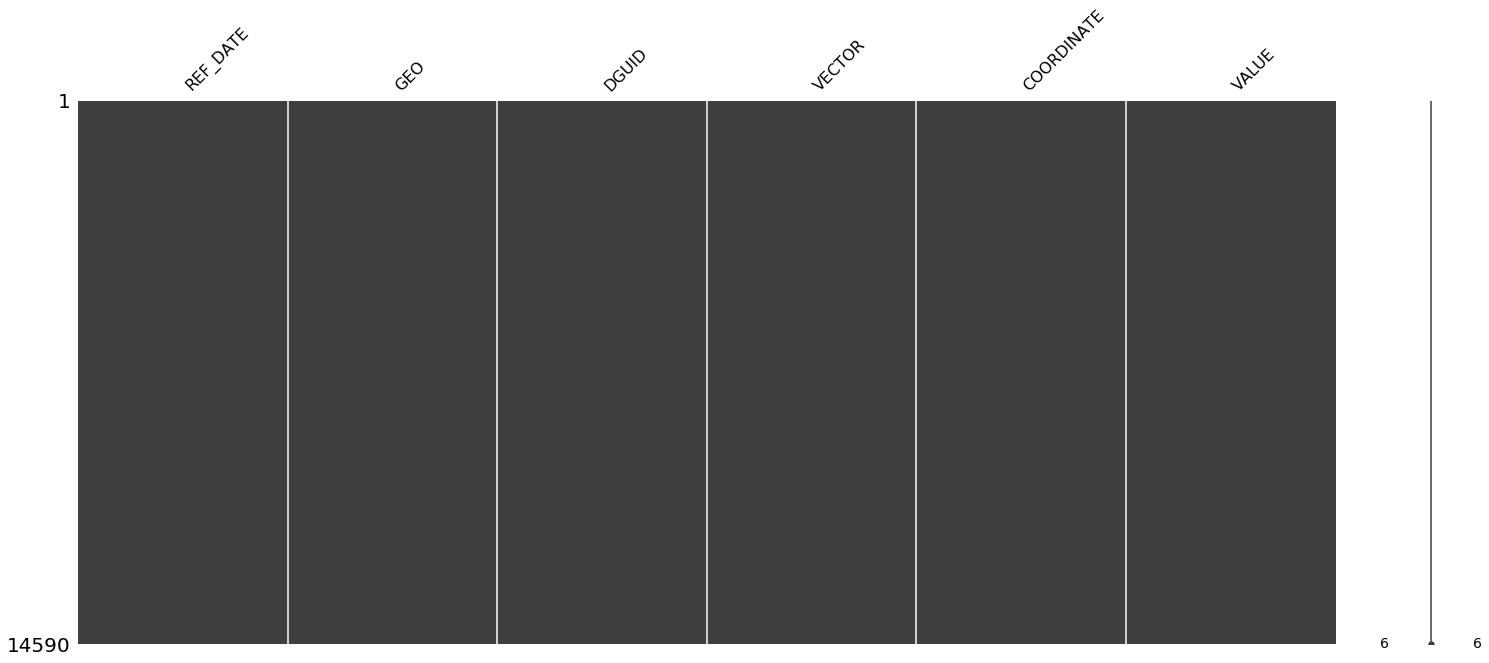

In [28]:
#verify no missing values
msno.matrix(housing_index3)

#14590 records with no missing values

In [29]:
#housing_index3 = housing_index3.reset_index(drop = 1)
#housing_index3

In [30]:
# Preview data - employment data
employment_data.head(5)

,REF_DATE,GEO,DGUID,Estimate,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2001-01,Canada,2016A000011124,Employment for all employees,Industrial aggregate including unclassified bu...,Persons,249,units,0,v79310773,1.1.1,12914635.0,NaN,NaN,NaN,0
1,2001-01,Canada,2016A000011124,Employment for all employees,Industrial aggregate excluding unclassified bu...,Persons,249,units,0,v79310776,1.1.2,12835441.0,NaN,NaN,NaN,0
2,2001-01,Canada,2016A000011124,Employment for all employees,Goods producing industries [11-33N],Persons,249,units,0,v79310775,1.1.3,2908409.0,NaN,NaN,NaN,0
3,2001-01,Canada,2016A000011124,Employment for all employees,"Forestry, logging and support [11N]",Persons,249,units,0,v79310774,1.1.4,70073.0,NaN,NaN,NaN,0
4,2001-01,Canada,2016A000011124,Employment for all employees,"Mining, quarrying, and oil and gas extraction ...",Persons,249,units,0,v79310777,1.1.10,136744.0,NaN,NaN,NaN,0


In [31]:
#preview rows with bad quality of data

employment_data["STATUS"].value_counts(dropna=False)

#".." not available for a specific reference period        
#"A" data quality: excellent
#"B" data quality: very good
#"C" data quality: good
#"D" data quality: acceptable
#"E" use with caution
#"F" too unreliable to be published
#"x" suppressed to meet the confidentiality requirements of the Statistics Act


A      75114
NaN    58603
x      17752
..      9021
B       3978
F       2416
C        573
D        207
E         28
Name: STATUS, dtype: int64

In [32]:
#remove bad quality rows

employment_data.drop(employment_data[employment_data['STATUS'] == "E"].index, inplace = True)
employment_data.drop(employment_data[employment_data['STATUS'] == "F"].index, inplace = True)
employment_data.drop(employment_data[employment_data['STATUS'] == "x"].index, inplace = True)
employment_data["STATUS"].value_counts(dropna=False)

#9021 rows with no data available - remove
employment_data.drop(employment_data[employment_data['STATUS'] == ".."].index, inplace = True)

VALUE Missing Values: 0
DATE Missing Values: 0
GEO Missing Values: 0
DGUID Missing Values: 0


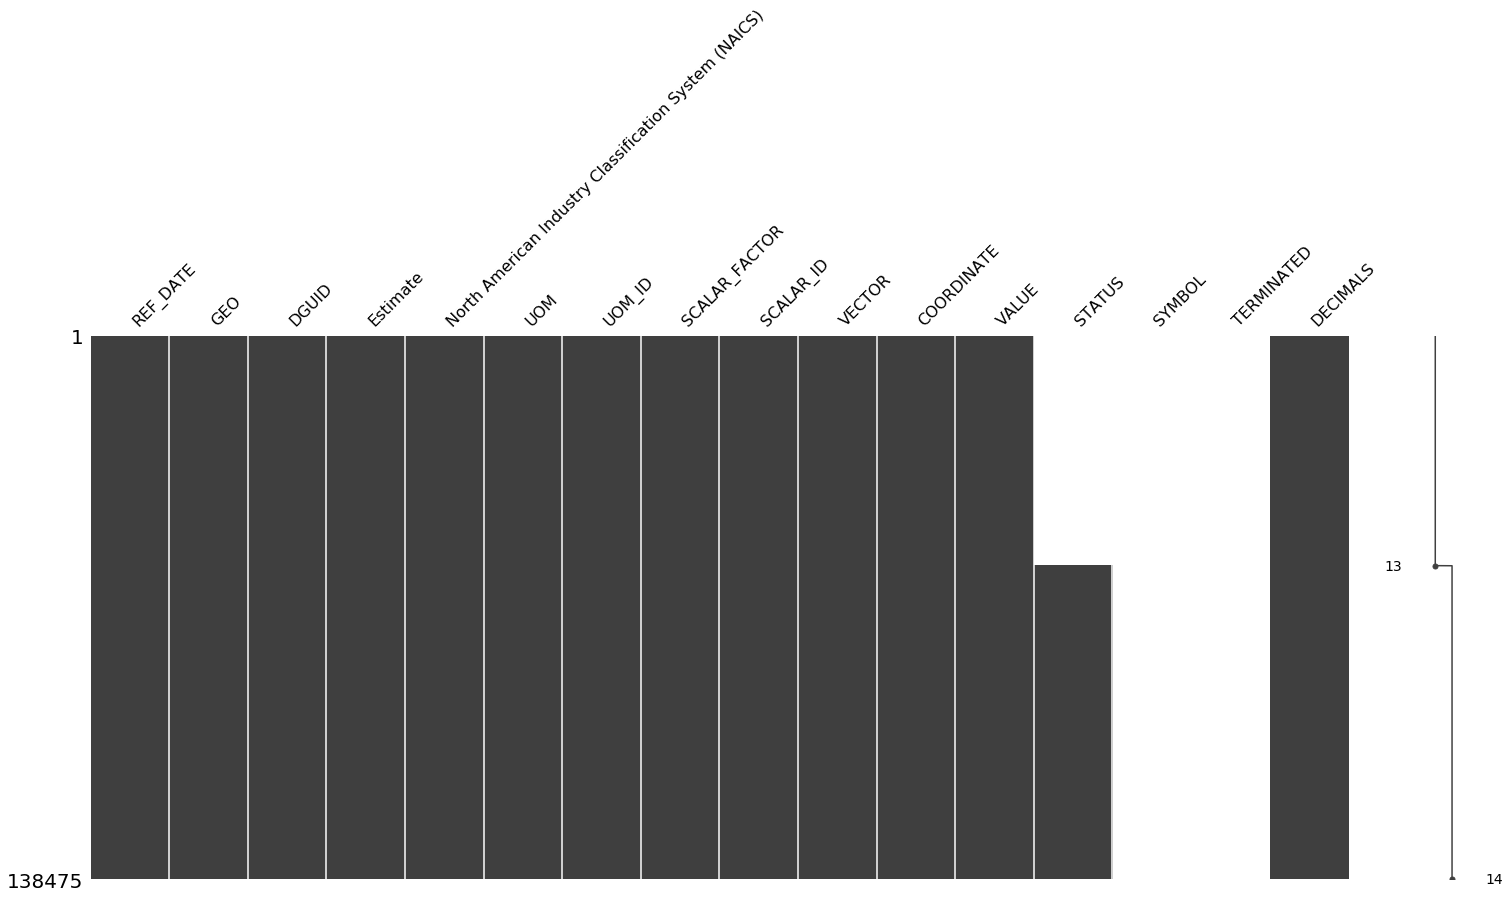

In [33]:
#preview missing values

msno.matrix(employment_data)

VALUE_msng_val_count2 = sum(pd.isnull(employment_data['VALUE']))
print("VALUE Missing Values: {}".format(VALUE_msng_val_count2))
DATE_msng_val_count2 = sum(pd.isnull(employment_data['REF_DATE']))
print("DATE Missing Values: {}".format(DATE_msng_val_count2))
GEO_msng_val_count2 = sum(pd.isnull(employment_data['GEO']))
print("GEO Missing Values: {}".format(GEO_msng_val_count2))
DGUID_msng_val_count2 = sum(pd.isnull(employment_data['DGUID']))
print("DGUID Missing Values: {}".format(DGUID_msng_val_count2))

#no missing values for date, DGUID, VALUE

In [34]:
#remove columns which will not be used / are blank
employment_data = employment_data.drop(["UOM_ID", "SCALAR_ID", "SCALAR_FACTOR", "STATUS", "SYMBOL", "TERMINATED", "DECIMALS"], axis=1)

In [35]:
#preview data types

print(employment_data.dtypes)

REF_DATE                                                  object
GEO                                                       object
DGUID                                                     object
Estimate                                                  object
North American Industry Classification System (NAICS)     object
UOM                                                       object
VECTOR                                                    object
COORDINATE                                                object
VALUE                                                    float64
dtype: object


In [36]:
#change data types

#change data type to date
employment_data["REF_DATE"] = pd.to_datetime(employment_data["REF_DATE"])

#change data types to factor
employment_data["GEO"] = employment_data["GEO"].astype('category')
employment_data["DGUID"] = employment_data["DGUID"].astype('category')
employment_data["Estimate"] = employment_data["Estimate"].astype('category')
employment_data["UOM"] = employment_data["UOM"].astype('category')

print(employment_data.dtypes)

REF_DATE                                                 datetime64[ns]
GEO                                                            category
DGUID                                                          category
Estimate                                                       category
North American Industry Classification System (NAICS)            object
UOM                                                            category
VECTOR                                                           object
COORDINATE                                                       object
VALUE                                                           float64
dtype: object


In [37]:
#preview of value distribution by Estimate UOM
employment_data.groupby(['Estimate', 'UOM'])['REF_DATE'].count()

#not sure which estimate is more correlated with housing index, so splitting into two queries to be joined. 
#Employment is expressed in number of persons, average weekly earnings in dollars 

Estimate                                                      UOM    
Average weekly earnings including overtime for all employees  Dollars    66466
Employment for all employees                                  Persons    72009
Name: REF_DATE, dtype: int64

In [38]:
#create separate data frames for 2 estimate types: avarage earnings (dollars)

average_dollars = employment_data.loc[(employment_data['Estimate'])  == 'Average weekly earnings including overtime for all employees']
average_dollars.head(3)

,REF_DATE,GEO,DGUID,Estimate,North American Industry Classification System (NAICS),UOM,VECTOR,COORDINATE,VALUE
27,2001-01-01,Canada,2016A000011124,Average weekly earnings including overtime for...,Industrial aggregate excluding unclassified bu...,Dollars,v79311153,1.2.2,657.36
28,2001-01-01,Canada,2016A000011124,Average weekly earnings including overtime for...,Goods producing industries [11-33N],Dollars,v79311152,1.2.3,819.68
29,2001-01-01,Canada,2016A000011124,Average weekly earnings including overtime for...,"Forestry, logging and support [11N]",Dollars,v79311151,1.2.4,769.36


In [39]:
#create separate data frames for 2 estimate types: employment (persons)

employment_persons = employment_data.loc[(employment_data['Estimate'])  == 'Employment for all employees']
employment_persons.head(3)

,REF_DATE,GEO,DGUID,Estimate,North American Industry Classification System (NAICS),UOM,VECTOR,COORDINATE,VALUE
0,2001-01-01,Canada,2016A000011124,Employment for all employees,Industrial aggregate including unclassified bu...,Persons,v79310773,1.1.1,12914635.0
1,2001-01-01,Canada,2016A000011124,Employment for all employees,Industrial aggregate excluding unclassified bu...,Persons,v79310776,1.1.2,12835441.0
2,2001-01-01,Canada,2016A000011124,Employment for all employees,Goods producing industries [11-33N],Persons,v79310775,1.1.3,2908409.0


In [40]:
#preview data - vacancy rate
vacancy_rate.head(3)

,REF_DATE,GEO,DGUID,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1971,Census metropolitan areas,NaN,Rate,257,units,0,v733334,1,3.9,NaN,NaN,NaN,1
1,1971,"Calgary, Alberta",2011S0503825,Rate,257,units,0,v733335,2,6.7,NaN,NaN,NaN,1
2,1971,"Edmonton, Alberta",2011S0503835,Rate,257,units,0,v733356,4,5.1,NaN,NaN,NaN,1


In [41]:
#preview rows with bad quality of data

vacancy_rate["STATUS"].value_counts(dropna=False)

NaN    1530
Name: STATUS, dtype: int64

VALUE Missing Values: 0
DATE Missing Values: 0
GEO Missing Values: 0
DGUID Missing Values: 76


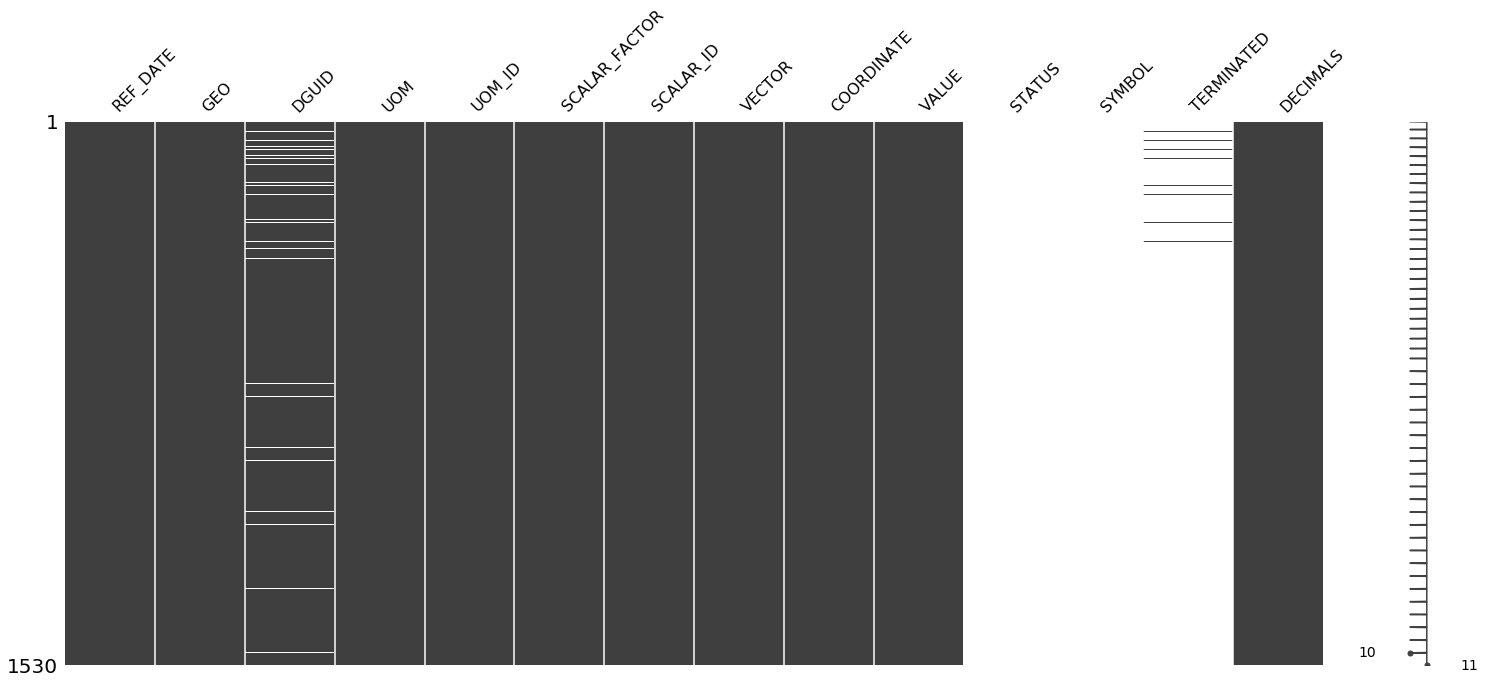

In [42]:
#preview missing values

msno.matrix(vacancy_rate)

VALUE_msng_val_count3 = sum(pd.isnull(vacancy_rate['VALUE']))
print("VALUE Missing Values: {}".format(VALUE_msng_val_count3))
DATE_msng_val_count3 = sum(pd.isnull(vacancy_rate['REF_DATE']))
print("DATE Missing Values: {}".format(DATE_msng_val_count3))
GEO_msng_val_count3 = sum(pd.isnull(vacancy_rate['GEO']))
print("GEO Missing Values: {}".format(GEO_msng_val_count3))
DGUID_msng_val_count3 = sum(pd.isnull(vacancy_rate['DGUID']))
print("DGUID Missing Values: {}".format(DGUID_msng_val_count3))

#no missing values for date, DGUID, VALUE

In [43]:
#preview rows with missing DGUID

vacancy_rates_DGUIDblanks = vacancy_rate.loc[(vacancy_rate['DGUID'].isnull()) == 1]
vacancy_rates_DGUIDblanks.groupby(['GEO'])['REF_DATE'].count()


GEO
Census metropolitan areas                  49
Montréal excluding Saint-Jérôme, Quebec    27
Name: REF_DATE, dtype: int64

In [44]:
# remove rows with blank DGUID values
vacancy_rate = vacancy_rate.dropna(subset=['DGUID'])

#check DGUID values
vacancy_rate["DGUID"].value_counts(dropna=False)

2011S0503537      49
2011S0503505      49
2011S0503580      49
2011S0503310      49
2011S0503555      49
2011S0503535      49
2011S0503835      49
2011S050535505    49
2011S050524505    49
2011S0503935      49
2011S0503933      49
2011S0503705      49
2011S0503001      49
2011S0503541      49
2011S0503559      49
2011S0503725      49
2011S0503421      49
2011S0503602      49
2011S0503205      49
2011S0503825      49
2011S0503408      48
2011S0503539      48
2011S0503595      48
2011S0503532      43
2011S0503442      38
2011S0503433      35
2011S0503550      24
2011S0503521      24
2011S0503915      24
2011S0503543      24
2011S0503568      24
2011S0503305      24
2011S0503529      24
2011S0503932      24
2011S0503462      22
Name: DGUID, dtype: int64

In [45]:
#remove columns which will not be used / are blank
vacancy_rate = vacancy_rate.drop(["UOM", "UOM_ID", "SCALAR_ID", "SCALAR_FACTOR", "STATUS", "SYMBOL", "DECIMALS"], axis=1)

In [46]:
#preview data types

print(vacancy_rate.dtypes)

REF_DATE        int64
GEO            object
DGUID          object
VECTOR         object
COORDINATE      int64
VALUE         float64
TERMINATED     object
dtype: object


In [47]:
#change data types

#change data type to date
vacancy_rate["REF_DATE"] = pd.to_datetime(vacancy_rate["REF_DATE"].astype(str), format = "%Y")

#change data types to factor
vacancy_rate["GEO"] = vacancy_rate["GEO"].astype('category')
vacancy_rate["DGUID"] = vacancy_rate["DGUID"].astype('category')
vacancy_rate["TERMINATED"] = vacancy_rate["TERMINATED"].astype('category')

print(vacancy_rate.dtypes)

REF_DATE      datetime64[ns]
GEO                 category
DGUID               category
VECTOR                object
COORDINATE             int64
VALUE                float64
TERMINATED          category
dtype: object


In [48]:
#output: housing_index3, employment_persons, average_dollars, vacancy_rate

Exploratory analysis

In [49]:
#review data ranges and frequency
print("housing_index3")
housing_index3["REF_DATE"].describe()

housing_index3


count                   14590
unique                    468
top       2019-09-01 00:00:00
freq                       39
first     1981-01-01 00:00:00
last      2019-12-01 00:00:00
Name: REF_DATE, dtype: object

In [50]:
print("employment_persons")
employment_persons["REF_DATE"].describe()

employment_persons


count                   72009
unique                    226
top       2019-04-01 00:00:00
freq                      332
first     2001-01-01 00:00:00
last      2019-10-01 00:00:00
Name: REF_DATE, dtype: object

In [51]:
print("average_dollars")
average_dollars["REF_DATE"].describe()

average_dollars


count                   66466
unique                    226
top       2003-06-01 00:00:00
freq                      302
first     2001-01-01 00:00:00
last      2019-10-01 00:00:00
Name: REF_DATE, dtype: object

In [52]:
print("vacancy_rate")
vacancy_rate["REF_DATE"].describe()

vacancy_rate


count                    1454
unique                     49
top       2019-01-01 00:00:00
freq                       35
first     1971-01-01 00:00:00
last      2019-01-01 00:00:00
Name: REF_DATE, dtype: object

In [53]:
#first full year for all 4 tables: 2001
#last full year for all 4 tables: 2018

#adjust data ranges and aggragate to annual

In [54]:
#HOUSING_INDEX
#add year column

housing_index4 = housing_index3
housing_index4['YEAR'] = pd.DatetimeIndex(housing_index4['REF_DATE']).year

#aggregate for annual - average

housing_index5 = housing_index4.groupby(['YEAR','DGUID', 'GEO'])['VALUE'].mean()
housing_index5 = housing_index5.reset_index()

#remove rows where year less than 2001 and greater than 2018
housing_index5.drop(housing_index5[housing_index5['YEAR'] < 2001].index, inplace = True)
housing_index5.drop(housing_index5[housing_index5['YEAR'] > 2018].index, inplace = True)

#set index on YEAR and DGUID
housing_index5 = housing_index5.set_index(['YEAR','DGUID','GEO'])

#rename column VALUE
housing_index5 = housing_index5.rename(columns={"VALUE": "HOUSING_INDEX_VALUE"})
housing_index5

HOUSING_INDEX_VALUE
YEAR DGUID       GEO                                             
2001 2011S05031  Alberta                                      NaN
                 Atlantic Region                              NaN
                 British Columbia                             NaN
                 Calgary, Alberta                             NaN
                 Canada                                       NaN
...                                                           ...
2018 2016A000259 Trois-Rivières, Quebec                       NaN
                 Vancouver, British Columbia                  NaN
                 Victoria, British Columbia                   NaN
                 Windsor, Ontario                             NaN
                 Winnipeg, Manitoba                           NaN

[27378 rows x 1 columns]

In [55]:
#EMPLOYMENT_PERSONS

employment_persons4 = employment_persons
employment_persons4['YEAR'] = pd.DatetimeIndex(employment_persons4['REF_DATE']).year

#aggregate for annual - average and rename column VALUE

employment_persons5 = employment_persons4.groupby(['YEAR','DGUID','GEO'])['VALUE'].mean()
employment_persons5 = employment_persons5.reset_index()

#remove rows where year less than 2001 and greater than 2018
employment_persons5.drop(employment_persons5[employment_persons5['YEAR'] < 2001].index, inplace = True)
employment_persons5.drop(employment_persons5[employment_persons5['YEAR'] > 2018].index, inplace = True)

#set index on YEAR and DGUID
employment_persons5 = employment_persons5.set_index(['YEAR','DGUID','GEO'])

#rename column VALUE
employment_persons5 = employment_persons5.rename(columns={"VALUE": "EMPLOYMENT_PERSONS_VALUE"})
employment_persons5

EMPLOYMENT_PERSONS_VALUE
YEAR DGUID          GEO                                           
2001 2016A000011124 Alberta                                    NaN
                    British Columbia                           NaN
                    Canada                            2.202550e+06
                    Manitoba                                   NaN
                    New Brunswick                              NaN
...                                                            ...
2018 2016A000262    Ontario                                    NaN
                    Prince Edward Island                       NaN
                    Quebec                                     NaN
                    Saskatchewan                               NaN
                    Yukon                                      NaN

[3528 rows x 1 columns]

In [56]:
#AVARAGE_DOLLARS

average_dollars4 = average_dollars
average_dollars4['YEAR'] = pd.DatetimeIndex(average_dollars4['REF_DATE']).year

#aggregate for annual - average and rename column VALUE

average_dollars5 = average_dollars4.groupby(['YEAR','DGUID','GEO'])['VALUE'].mean()
average_dollars5 = average_dollars5.reset_index()

#remove rows where year less than 2001 and greater than 2018
average_dollars5.drop(average_dollars5[average_dollars5['YEAR'] < 2001].index, inplace = True)
average_dollars5.drop(average_dollars5[average_dollars5['YEAR'] > 2018].index, inplace = True)

#set index on YEAR and DGUID
average_dollars5 = average_dollars5.set_index(['YEAR','DGUID','GEO'])

#rename column VALUE
average_dollars5 = average_dollars5.rename(columns={"VALUE": "AV_DOLLARS_VALUE"})
average_dollars5

AV_DOLLARS_VALUE
YEAR DGUID          GEO                                   
2001 2016A000011124 Alberta                            NaN
                    British Columbia                   NaN
                    Canada                      715.439583
                    Manitoba                           NaN
                    New Brunswick                      NaN
...                                                    ...
2018 2016A000262    Ontario                            NaN
                    Prince Edward Island               NaN
                    Quebec                             NaN
                    Saskatchewan                       NaN
                    Yukon                              NaN

[3528 rows x 1 columns]

In [57]:
#VACANCY_RATE

vacancy_rate4 = vacancy_rate
vacancy_rate4['YEAR'] = pd.DatetimeIndex(vacancy_rate4['REF_DATE']).year

#aggregate for annual - average and rename column VALUE to INDEX_VALUE

vacancy_rate5 = vacancy_rate4.groupby(['YEAR','DGUID','GEO'])['VALUE'].mean()
vacancy_rate5 = vacancy_rate5.reset_index()

#remove rows where year less than 2001 and greater than 2018
vacancy_rate5.drop(vacancy_rate5[vacancy_rate5['YEAR'] < 2001].index, inplace = True)
vacancy_rate5.drop(vacancy_rate5[vacancy_rate5['YEAR'] > 2018].index, inplace = True)

#set index on YEAR and DGUID
vacancy_rate5 = vacancy_rate5.set_index(['YEAR','DGUID','GEO'])

#rename column VALUE
vacancy_rate5 = vacancy_rate5.rename(columns={"VALUE": "VACANCY_RATE_VALUE"})
vacancy_rate5

VACANCY_RATE_VALUE
YEAR DGUID          GEO                                                     
2001 2011S0503001   Abbotsford-Mission, British Columbia                 NaN
                    Barrie, Ontario                                      NaN
                    Brantford, Ontario                                   NaN
                    Calgary, Alberta                                     NaN
                    Edmonton, Alberta                                    NaN
...                                                                      ...
2018 2011S050535505 Trois-Rivières, Quebec                               NaN
                    Vancouver, British Columbia                          NaN
                    Victoria, British Columbia                           NaN
                    Windsor, Ontario                                     NaN
                    Winnipeg, Manitoba                                   NaN

[22050 rows x 1 columns]

In [58]:
#merge tables on index

all_values = pd.concat([housing_index5, employment_persons5, average_dollars5, vacancy_rate5], axis=1)
all_values.reset_index()

#remove rows with NaNs
all_values = all_values.dropna(thresh=1).reset_index()
all_values

,YEAR,DGUID,GEO,HOUSING_INDEX_VALUE,EMPLOYMENT_PERSONS_VALUE,AV_DOLLARS_VALUE,VACANCY_RATE_VALUE
0,2001,2011S0503001,"St. John's, Newfoundland and Labrador",NaN,NaN,NaN,2.2
1,2001,2011S05031,"St. John's, Newfoundland and Labrador",51.808333,NaN,NaN,NaN
2,2001,2011S0503205,"Halifax, Nova Scotia",66.166667,NaN,NaN,2.9
3,2001,2011S0503305,"Moncton, New Brunswick",NaN,NaN,NaN,2.0
4,2001,2011S0503310,"Saint John, New Brunswick",NaN,NaN,NaN,5.7
...,...,...,...,...,...,...,...
969,2018,2016A000248,Alberta,99.116667,330732.306667,1251.749443,NaN
970,2018,2016A000259,British Columbia,108.808333,373670.676667,1118.380243,NaN
971,2018,2016A000260,Yukon,NaN,4240.369048,1027.658520,NaN
972,2018,2016A000261,Northwest Territories,NaN,4949.530303,1311.551716,NaN


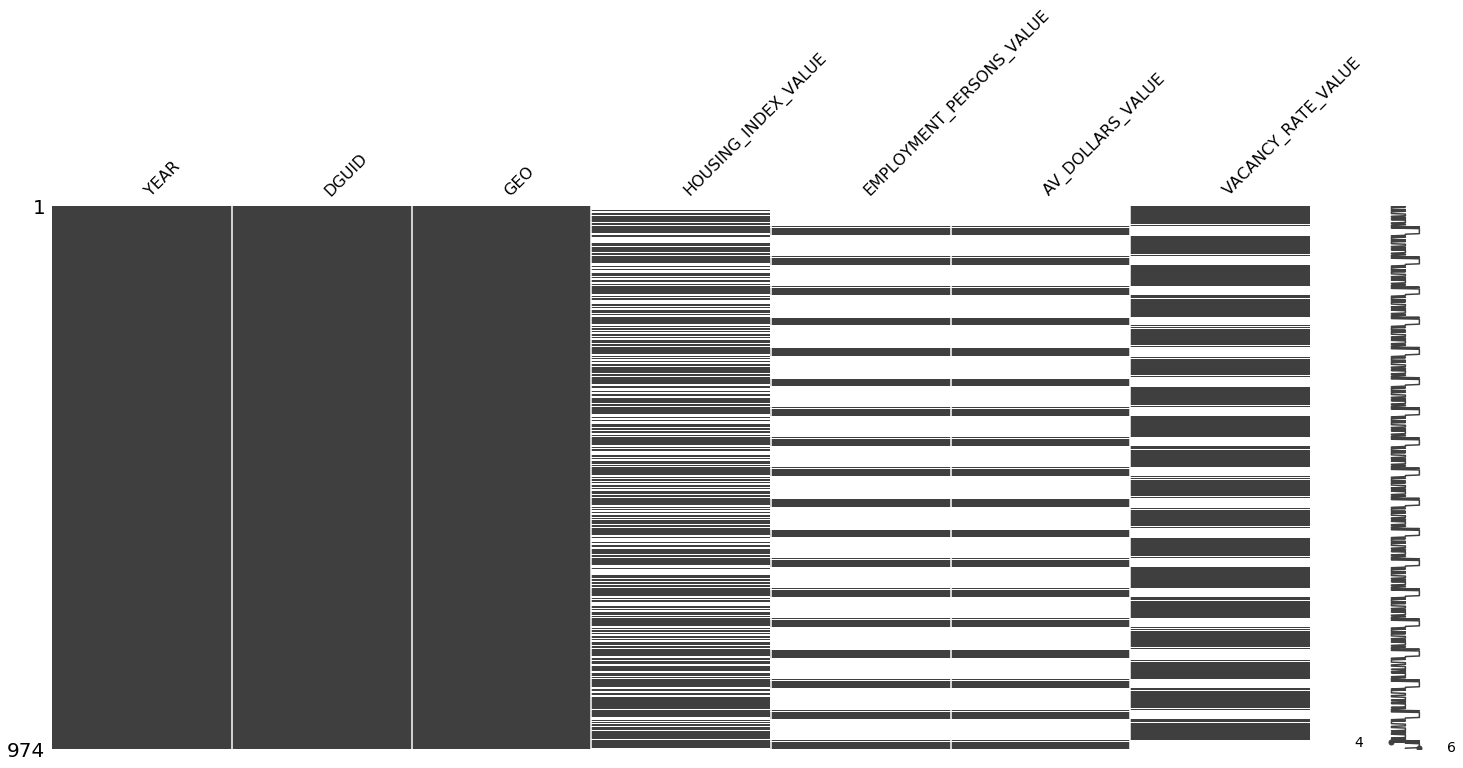

In [59]:
#review results
msno.matrix(all_values)

#regions are not matchnig - inner join has no values
#not able to calculate correlation for year, GDUID index
#aggregate DGUID by province (average)

In [60]:
#list GEO unique
all_values_GEO_set = set(all_values["GEO"])
all_values_GEO_list = list(all_values_GEO_set)
all_values_GEO_list

["St. John's, Newfoundland and Labrador",
 'Saguenay, Quebec',
 'Kelowna, British Columbia',
 'Oshawa, Ontario',
 'Prince Edward Island',
 'New Brunswick',
 'British Columbia',
 'Toronto, Ontario',
 'Ontario',
 'Abbotsford-Mission, British Columbia',
 'Alberta',
 'Winnipeg, Manitoba',
 'Northwest Territories',
 'Regina, Saskatchewan',
 'Ottawa-Gatineau, Quebec part, Ontario/Quebec',
 'Québec, Quebec',
 'Trois-Rivières, Quebec',
 'Greater Sudbury, Ontario',
 'Yukon',
 'Nunavut',
 'Victoria, British Columbia',
 'Sherbrooke, Quebec',
 'Ottawa-Gatineau, Ontario part, Ontario/Quebec',
 'Saint John, New Brunswick',
 'Kitchener-Cambridge-Waterloo, Ontario',
 'Montréal, Quebec',
 'Quebec',
 'London, Ontario',
 'Charlottetown, Prince Edward Island',
 'Saskatoon, Saskatchewan',
 'Edmonton, Alberta',
 'Manitoba',
 'Kingston, Ontario',
 'Moncton, New Brunswick',
 'Vancouver, British Columbia',
 'Halifax, Nova Scotia',
 'Ottawa-Gatineau, Ontario/Quebec',
 'Hamilton, Ontario',
 'St. Catharines-Niaga

In [61]:
#assign province to each GEO

province_list = ['Yukon',
 'Ontario',
 'Ontario',
 'Ontario',
 'Ontario',
 'British Columbia',
 'Quebec',
 'Ontario',
 'Ontario',
 'Ontario',
 'Saskatchewan',
 'Quebec',
 'Prince Edward Island',
 'Atlantic Region',
 'Quebec',
 'Nova Scotia',
 'Saskatchewan',
 'Ontario',
 'Quebec',
 'British Columbia',
 'Alberta',
 'Alberta',
 'Prairie Region',
 'Newfoundland and Labrador',
 'Ontario',
 'New Brunswick',
 'Ontario',
 'Quebec',
 'Northwest Territories',
 'Ontario',
 'British Columbia',
 'British Columbia',
 'Prince Edward Island',
 'Newfoundland and Labrador',
 'Quebec',
 'British Columbia',
 'Ontario',
 'Nunavut',
 'Canada',
 'Alberta',
 'Ontario',
 'New Brunswick',
 'Ontario',
 'New Brunswick',
 'Nova Scotia',
 'Manitoba',
 'Saskatchewan',
 'Quebec',
 'Ontario',
 'Manitoba',
 'Ontario',
 'Ontario']

#create dataftrame GEO + province pairs

GEO_Province = pd.DataFrame()
GEO_Province['GEO'] = all_values_GEO_list
GEO_Province['Province'] = province_list
GEO_Province

,GEO,Province
0,"St. John's, Newfoundland and Labrador",Yukon
1,"Saguenay, Quebec",Ontario
2,"Kelowna, British Columbia",Ontario
3,"Oshawa, Ontario",Ontario
4,Prince Edward Island,Ontario
5,New Brunswick,British Columbia
6,British Columbia,Quebec
7,"Toronto, Ontario",Ontario
8,Ontario,Ontario
9,"Abbotsford-Mission, British Columbia",Ontario


In [62]:
#add province column to all_values

GEO_Province_index = GEO_Province.set_index('GEO')['Province']
all_values['Province'] = all_values['GEO'].map(GEO_Province_index)

all_values


,YEAR,DGUID,GEO,HOUSING_INDEX_VALUE,EMPLOYMENT_PERSONS_VALUE,AV_DOLLARS_VALUE,VACANCY_RATE_VALUE,Province
0,2001,2011S0503001,"St. John's, Newfoundland and Labrador",NaN,NaN,NaN,2.2,Yukon
1,2001,2011S05031,"St. John's, Newfoundland and Labrador",51.808333,NaN,NaN,NaN,Yukon
2,2001,2011S0503205,"Halifax, Nova Scotia",66.166667,NaN,NaN,2.9,British Columbia
3,2001,2011S0503305,"Moncton, New Brunswick",NaN,NaN,NaN,2.0,Newfoundland and Labrador
4,2001,2011S0503310,"Saint John, New Brunswick",NaN,NaN,NaN,5.7,Newfoundland and Labrador
...,...,...,...,...,...,...,...,...
969,2018,2016A000248,Alberta,99.116667,330732.306667,1251.749443,NaN,Saskatchewan
970,2018,2016A000259,British Columbia,108.808333,373670.676667,1118.380243,NaN,Quebec
971,2018,2016A000260,Yukon,NaN,4240.369048,1027.658520,NaN,Quebec
972,2018,2016A000261,Northwest Territories,NaN,4949.530303,1311.551716,NaN,Prince Edward Island


In [63]:
#aggragate all_values - average of province

all_values_province = all_values.groupby(['YEAR','Province'])['HOUSING_INDEX_VALUE', 'EMPLOYMENT_PERSONS_VALUE', 'AV_DOLLARS_VALUE',
'VACANCY_RATE_VALUE'].mean().dropna().reset_index()

all_values_province

,YEAR,Province,HOUSING_INDEX_VALUE,EMPLOYMENT_PERSONS_VALUE,AV_DOLLARS_VALUE,VACANCY_RATE_VALUE
0,2001,British Columbia,62.533333,4.660451e+04,651.153958,1.900000
1,2001,New Brunswick,59.079167,2.202550e+06,715.439583,0.850000
2,2001,Ontario,62.211364,3.094027e+05,645.782085,2.518182
3,2001,Quebec,62.708333,1.455693e+05,712.294208,1.040000
4,2001,Saskatchewan,57.591667,1.634547e+05,649.716091,4.400000
...,...,...,...,...,...,...
85,2018,British Columbia,101.879167,5.612521e+04,1065.639001,3.400000
86,2018,New Brunswick,103.470833,2.585179e+06,1120.981378,1.600000
87,2018,Ontario,101.303472,3.610820e+05,1024.418376,3.063636
88,2018,Quebec,107.630000,1.889555e+05,1073.019382,2.000000


In [64]:
#calculate correlation

all_values_province.set_index(['YEAR','Province']).corr()

#strong correlation between AV_DOLLARS and HOUSING_INDEX (0.701385), weak for HOUSING_INDEX ~ other parameters

,HOUSING_INDEX_VALUE,EMPLOYMENT_PERSONS_VALUE,AV_DOLLARS_VALUE,VACANCY_RATE_VALUE
HOUSING_INDEX_VALUE,1.000000,0.011146,0.916782,0.394644
EMPLOYMENT_PERSONS_VALUE,0.011146,1.000000,0.203625,-0.192798
AV_DOLLARS_VALUE,0.916782,0.203625,1.000000,0.381146
VACANCY_RATE_VALUE,0.394644,-0.192798,0.381146,1.000000


Time series analysis

In [65]:
#ARIMA MODEL ON full HOUSING_INDEX series (input: housing_index3)
#prepare list with values average for Canada for ARIMA model

housing_index_series_Canada = housing_index3.groupby(['REF_DATE'])['VALUE'].mean()
housing_index_series_Canada

#468 rows, data from Jan 1981 to Dec 2019 in monthly intervals

REF_DATE
1981-01-01     46.047368
1981-02-01     46.515789
1981-03-01     46.926316
1981-04-01     47.415789
1981-05-01     47.915789
                 ...    
2019-08-01    102.748649
2019-09-01    103.035897
2019-10-01    103.184615
2019-11-01    103.066667
2019-12-01    103.225641
Name: VALUE, Length: 468, dtype: float64

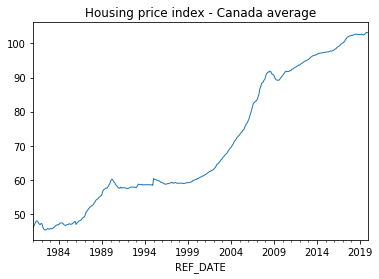

In [66]:
#plot time series

housing_index_series_Canada.plot(linewidth=1, title="Housing price index - Canada average");

In [67]:
# check if the series is stationary using the Augmented Dickey Fuller test
# if P Value > 0.05 we go ahead with finding the order of differencing

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(housing_index_series_Canada)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# P-value is greater than the significance level: difference the series and see how the autocorrelation plot looks like

ADF Statistic: -0.085376
p-value: 0.950876


In [68]:
from pmdarima.arima import auto_arima

In [69]:
# ARIMA model

stepwise_model = auto_arima(housing_index_series_Canada, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

# The resulting best model parameters gave us an AIC value of -139.3733784073505
# Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-139.373, BIC=-114.652

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-138.457, BIC=-117.855, Time=5.159 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=211.260, BIC=219.501, Time=0.141 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=3.613, BIC=20.094, Time=1.287 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-47.429, BIC=-30.948, Time=4.025 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=209.269, BIC=213.390, Time=0.156 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=85.394, BIC=101.876, Time=0.570 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-139.373, BIC=-114.652, Time=8.027 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close 

In [70]:
#train test split
train = housing_index_series_Canada.loc['1981-01-01':'2014-12-01']
test = housing_index_series_Canada.loc['2015-01-01': '2019-12-01']

In [71]:
#train the model
stepwise_model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [72]:
#evaluation
future_forecast = stepwise_model.predict(n_periods=60)
print(future_forecast)

[ 97.57196885  97.7831141   97.94880468  98.09329595  98.27354915
  98.41112018  98.5243061   98.68085411  98.81621288  98.90797448
  99.08778878  99.19381451  99.41999127  99.68191282  99.90203727
 100.0927095  100.31319631 100.4875306  100.63484372 100.81933881
 100.98491807 101.09573185 101.30087189 101.42538775 101.66853533
 101.9452393  102.17930335 102.38237051 102.61400718 102.79853941
 102.95525729 103.14819368 103.32193217 103.43971824 103.65195293
 103.78278848 104.03190324 104.31420789 104.55363236 104.7617944
 104.99830367 105.18752598 105.34877886 105.5460967  105.72412395
 105.84605116 106.06238235 106.19721267 106.45025734 106.73643159
 106.9796792  107.19162021 107.43187092 107.62480301 107.7897386
 107.99071442 108.17238124 108.29792728 108.51786541 108.6562879 ]


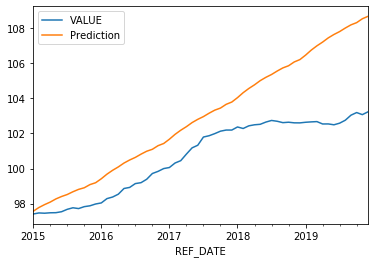

In [73]:
#Plot value vs prediction

future_forecast = pd.DataFrame(future_forecast,index = test.index,columns = ['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

#https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
#https://community.plot.ly/t/why-plotlyrequesterror-no-message/8307/9

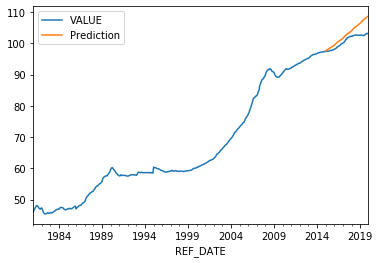

In [74]:
#value and prediction chart
pd.concat([housing_index_series_Canada,future_forecast],axis=1).plot()

In [75]:
#Evaluate model - Mean Squared Error: test vs future_forecast for 5 years

mse = ((future_forecast['Prediction'] - test) ** 2).mean()

print('The Mean Squared Error of ARIMA forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of ARIMA forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of ARIMA forecasts is 7.31
The Root Mean Squared Error of ARIMA forecasts is 2.7


In [76]:
# calculate MAPE (expressed in %)

MAPE = np.mean(np.abs((test - future_forecast['Prediction']) / test)) * 100

print('Mean absolute percentage error is {}%'.format(round(MAPE, 2)))

Mean absolute percentage error is 2.22%


In [77]:
# ARIMA prediction

#train the model
stepwise_model.fit(housing_index_series_Canada)

#prediction for next 5 years
future_forecast_ARIMA = stepwise_model.predict(n_periods=60)
future_forecast_ARIMA

array([103.39954731, 103.60376382, 103.77232108, 103.90682531,
       104.08197451, 104.20717773, 104.33968947, 104.49083594,
       104.64155334, 104.74305836, 104.87995334, 104.98545823,
       105.18389409, 105.41477467, 105.60614603, 105.77212763,
       105.96964338, 106.11647808, 106.25874783, 106.41424764,
       106.55872829, 106.66098717, 106.8234738 , 106.92844367,
       107.13255754, 107.36902941, 107.56544111, 107.7369892 ,
       107.93913877, 108.09039798, 108.23597196, 108.39421381,
       108.54045585, 108.64497799, 108.8117328 , 108.91872535,
       109.12532804, 109.36423548, 109.56299697, 109.73690447,
       109.94130582, 110.09477366, 110.24244047, 110.402709  ,
       110.55087921, 110.65735716, 110.82622301, 110.93512822,
       111.1436733 , 111.3845107 , 111.58518809, 111.76100634,
       111.96730429, 112.12266068, 112.27220252, 112.43433723,
       112.5843625 , 112.69269535, 112.86342693, 112.97417943])

In [78]:
#prepare data for random forest
housing_index_series_Canada2 = housing_index3.groupby(['REF_DATE'])['VALUE'].mean().reset_index()
housing_index_series_Canada2

,REF_DATE,VALUE
0,1981-01-01,46.047368
1,1981-02-01,46.515789
2,1981-03-01,46.926316
3,1981-04-01,47.415789
4,1981-05-01,47.915789
...,...,...
463,2019-08-01,102.748649
464,2019-09-01,103.035897
465,2019-10-01,103.184615
466,2019-11-01,103.066667


In [97]:
#random forest model

x = housing_index_series_Canada2['REF_DATE'].values
y = housing_index_series_Canada2['VALUE'].values

#60 periods set for evaluating the model

X_train = x[:-60]
X_val = x[-60:]
y_train = y[:-60]
y_val = y[-60:]

# https://medium.com/datadriveninvestor/why-wont-time-series-data-and-random-forests-work-very-well-together-3c9f7b271631

In [101]:
# fitting the model

model_rf = RandomForestRegressor(n_estimators=10)

#X array-like or sparse matrix of shape (n_samples, n_features)
#The training input samples. Internally, its dtype will be converted to dtype=np.float32. If a sparse matrix is provided, it will be converted into a sparse csc_matrix.
#y array-like of shape (n_samples,) or (n_samples, n_outputs)
#The target values (class labels in classification, real numbers in regression).

model_rf.fit(X_train.reshape(-1, 1), y_train)

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [109]:
# predicion for test set
prediction_rf = model_rf.predict(X_val.reshape(-1, 1))
prediction_rf
#predictions are flat

array([97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303,
       97.3830303, 97.3830303, 97.3830303, 97.3830303, 97.3830303])

In [105]:
#Evaluate model - Mean Squared Error: test vs future_forecast for 5 years

mse_RF = ((prediction_rf - y_val) ** 2).mean()

print('The Mean Squared Error of random forest forecasts is {}'.format(round(mse_RF, 2)))
print('The Root Mean Squared Error of random forest forecasts is {}'.format(round(np.sqrt(mse_RF), 2)))

The Mean Squared Error of random forest forecasts is 15.09
The Root Mean Squared Error of random forest forecasts is 3.88


In [110]:
# calculate MAPE (expressed in %)

MAPE_RF = np.mean(np.abs((prediction_rf - y_val) / y_val)) * 100

print('Mean absolute percentage error is {}%'.format(round(MAPE_RF, 2)))

Mean absolute percentage error is 3.23%


In [121]:
future_periods = ['2020-01-01',
'2020-02-01',
'2020-03-01',
'2020-04-01',
'2020-05-01',
'2020-06-01',
'2020-07-01',
'2020-08-01',
'2020-09-01',
'2020-10-01',
'2020-11-01',
'2020-12-01',
'2021-01-01',
'2021-02-01',
'2021-03-01',
'2021-04-01',
'2021-05-01',
'2021-06-01',
'2021-07-01',
'2021-08-01',
'2021-09-01',
'2021-10-01',
'2021-11-01',
'2021-12-01',
'2022-01-01',
'2022-02-01',
'2022-03-01',
'2022-04-01',
'2022-05-01',
'2022-06-01',
'2022-07-01',
'2022-08-01',
'2022-09-01',
'2022-10-01',
'2022-11-01',
'2022-12-01',
'2023-01-01',
'2023-02-01',
'2023-03-01',
'2023-04-01',
'2023-05-01',
'2023-06-01',
'2023-07-01',
'2023-08-01',
'2023-09-01',
'2023-10-01',
'2023-11-01',
'2023-12-01',
'2024-01-01',
'2024-02-01',
'2024-03-01',
'2024-04-01',
'2024-05-01',
'2024-06-01',
'2024-07-01',
'2024-08-01',
'2024-09-01',
'2024-10-01',
'2024-11-01',
'2024-12-01']

In [127]:
future_periods = pd.to_datetime(future_periods).values

In [128]:
#Random forest - future forecast

model_rf.fit(x.reshape(-1, 1), y)
future_forecast_rf = model_rf.predict(future_periods.reshape(-1, 1))


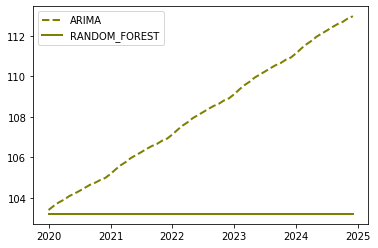

In [129]:
# plot value vs future prediction for both models

data = {'ARIMA': future_forecast_ARIMA,
        'RANDOM_FOREST': future_forecast_rf,
        'period': future_periods}


plt.plot( 'period', 'ARIMA', data=data, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.plot( 'period', 'RANDOM_FOREST', data=data, marker='', color='olive', linewidth=2)
plt.legend()